In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import yfinance as yf
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from datetime import datetime as dt
# pd.options.display.max_rows = 4000

In [2]:
# We should take bigger timeframe for our model to be accurate
ticker = 'AAPL'
start_date = dt(2010, 1, 1)
end_date = dt.now()
# User can take any stock picker
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [3]:
df.shape

(3508, 6)

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478998,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490200,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386965,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375156,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417541,447610800
...,...,...,...,...,...,...
2023-12-04,189.979996,190.050003,187.449997,189.429993,189.429993,43389500
2023-12-05,190.210007,194.399994,190.179993,193.419998,193.419998,66628400
2023-12-06,194.449997,194.759995,192.110001,192.320007,192.320007,41089700


In [5]:
df.to_csv('output.csv', index=False)

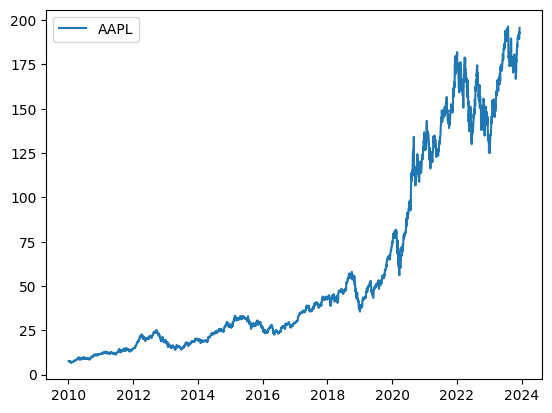

In [6]:
plt.plot(df['Close'],label = 'AAPL')
plt.legend()

In [7]:
# Dropping Date and Adj Close Column
df = df.drop(['Adj Close'], axis = 1)

In [8]:
df = df.reset_index(drop = True)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


In [9]:
# 100 days moving average
# Moving average for first 100 days is not defined as we need at least 100
# days data to get 100 day moving average
ma100 = df.Close.rolling(100).mean()
ma100

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
3503    181.567801
3504    181.595101
3505    181.578401
3506    181.583801
3507    181.589901
Name: Close, Length: 3508, dtype: float64

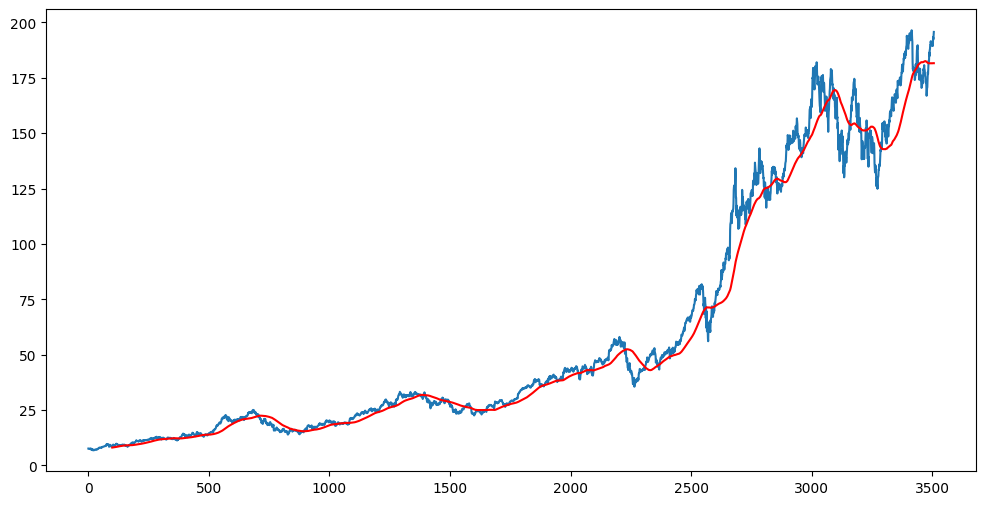

In [10]:
# Plotting 100 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'red')

In [11]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
3503    175.44575
3504    175.65010
3505    175.86930
3506    176.09610
3507    176.32765
Name: Close, Length: 3508, dtype: float64

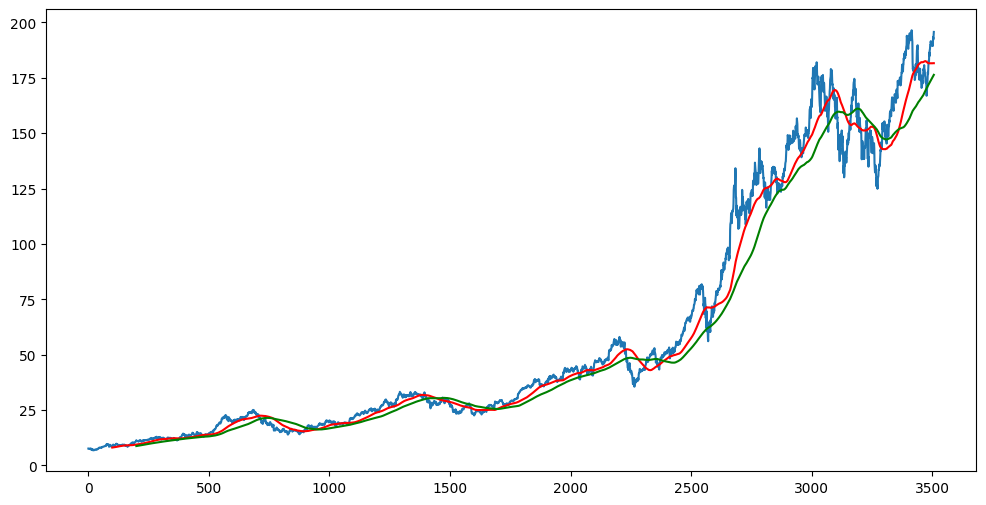

In [12]:
# Plotting 200 days moving average graph
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100,'r')
plt.plot(ma200,'g')

In [13]:
# Splitting data into training and testing
# We take 70% data for training and 30% for testing
data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.7)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.7):int (len(df))])
print(data_training.shape)
print(data_testing.shape)

(2455, 1)
(1053, 1)


In [14]:
# Now we should move on to scaling down data for LSTM model
# We have to scale down it between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [15]:
# scaler.fit_transform return an array
data_training_array = scaler.fit_transform(data_training)
data_training_array

array([[0.01533047],
       [0.01558878],
       [0.01320823],
       ...,
       [0.96344693],
       [0.93593449],
       [0.94502388]])

In [16]:
# Shape of data training array
data_training_array.shape

(2455, 1)

In [17]:
# First 100 days will be x_train
# And predicted value will be y_train
# In short x_train predicts y_train
x_train = []
y_train = []
for i in range(100,data_training_array.shape[0]):
  x_train.append(data_training_array[i-100:i])
  y_train.append(data_training_array[i,0])

In [18]:
# Converting x_train and y_train to numpy array
x_train, y_train = np.array(x_train),np.array(y_train)

In [19]:
x_train.shape
# Assume this as 2354 2D matrices each with 100 rows and 1 column

(2355, 100, 1)

In [20]:
y_train.shape

(2355,)

In [21]:
x_train

array([[[0.01533047],
        [0.01558878],
        [0.01320823],
        ...,
        [0.03819355],
        [0.03711847],
        [0.03634356]],

       [[0.01558878],
        [0.01320823],
        [0.01293595],
        ...,
        [0.03711847],
        [0.03634356],
        [0.04279409]],

       [[0.01320823],
        [0.01293595],
        [0.01391331],
        ...,
        [0.03634356],
        [0.04279409],
        [0.04525843]],

       ...,

       [[0.84679984],
        [0.82950064],
        [0.77349834],
        ...,
        [0.94047915],
        [0.93525034],
        [0.96041716]],

       [[0.82950064],
        [0.77349834],
        [0.78786545],
        ...,
        [0.93525034],
        [0.96041716],
        [0.96344693]],

       [[0.77349834],
        [0.78786545],
        [0.79890951],
        ...,
        [0.96041716],
        [0.96344693],
        [0.93593449]]])

In [22]:
y_train

array([0.04279409, 0.04525843, 0.04801596, ..., 0.96344693, 0.93593449,
       0.94502388])

# Creating ML Model using LSTM (Long Short Time Memory)

In [23]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
import keras as keras

In [24]:
model = Sequential()
# Adding Layers
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True,
               input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

# Connecting all layers
model.add(Dense(units = 1))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [53]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(x_train,y_train, epochs = 100)

Epoch 1/100
74/74 [==============================] - 16s 164ms/step - loss: 0.0361
Epoch 2/100
74/74 [==============================] - 12s 165ms/step - loss: 0.0076
Epoch 3/100
74/74 [==============================] - 12s 157ms/step - loss: 0.0075
Epoch 4/100
74/74 [==============================] - 12s 158ms/step - loss: 0.0063
Epoch 5/100
74/74 [==============================] - 12s 158ms/step - loss: 0.0065
Epoch 6/100
74/74 [==============================] - 12s 156ms/step - loss: 0.0062
Epoch 7/100
74/74 [==============================] - 12s 157ms/step - loss: 0.0052
Epoch 8/100
74/74 [==============================] - 11s 154ms/step - loss: 0.0056
Epoch 9/100
74/74 [==============================] - 12s 158ms/step - loss: 0.0059
Epoch 10/100
74/74 [==============================] - 11s 153ms/step - loss: 0.0050
Epoch 11/100
74/74 [==============================] - 11s 153ms/step - loss: 0.0051
Epoch 12/100
74/74 [==============================] - 11s 153ms/step - loss: 0.0049
E

In [55]:
# model.save('keras_model100.keras')

In [56]:
data_testing.tail(10)

,Close
3498,189.789993
3499,190.399994
3500,189.369995
3501,189.949997
3502,191.240005
3503,189.429993
3504,193.419998
3505,192.320007
3506,194.270004
3507,195.710007


In [57]:
past_100_days = data_training.tail(100)
past_100_days

,Close
2355,47.165001
2356,47.730000
2357,47.520000
2358,47.250000
2359,45.772499
...,...
2450,54.705002
2451,55.992500
2452,56.147499
2453,54.740002


In [58]:
final_df = pd.concat([past_100_days, data_testing], ignore_index=True)

In [59]:
final_df

,Close
0,47.165001
1,47.730000
2,47.520000
3,47.250000
4,45.772499
...,...
1148,189.429993
1149,193.419998
1150,192.320007
1151,194.270004


In [60]:
final_df.tail(10)

,Close
1143,189.789993
1144,190.399994
1145,189.369995
1146,189.949997
1147,191.240005
1148,189.429993
1149,193.419998
1150,192.320007
1151,194.270004
1152,195.710007


In [61]:
# To scale down input data
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02507755],
       [0.02876734],
       [0.02739592],
       ...,
       [0.97302864],
       [0.98576331],
       [0.99516741]])

In [62]:
input_data.shape

(1153, 1)

In [63]:
x_test = []
y_test = []
for i in range (100, input_data.shape[0]):
  x_test.append(input_data[i-100:i])
  y_test.append(input_data[i,0])

In [64]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)

(1053, 100, 1)


In [65]:
y_test

array([0.08768978, 0.08777142, 0.08342856, ..., 0.97302864, 0.98576331,
       0.99516741])

In [66]:
y_test.shape

(1053,)

In [67]:
# Making predictions
# m1 = keras.models.load_model('keras_model.keras')
m2 = keras.models.load_model('keras_model100.keras')
y_predicted = m2.predict(x_test)

33/33 [==============================] - 2s 51ms/step


In [68]:
y_predicted.shape

(1053, 1)

In [69]:
y_predicted

array([[0.09566888],
       [0.09637338],
       [0.09710297],
       ...,
       [0.92975485],
       [0.9312154 ],
       [0.9333991 ]], dtype=float32)

In [70]:
y_predicted_original = scaler.inverse_transform(y_predicted.reshape(-1, 1))

y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


In [71]:
y_predicted_original

array([[ 57.974297],
       [ 58.082172],
       [ 58.19389 ],
       ...,
       [185.69371 ],
       [185.91736 ],
       [186.25174 ]], dtype=float32)

In [72]:
y_test_original

array([[ 56.75249863],
       [ 56.76499939],
       [ 56.09999847],
       ...,
       [192.32000732],
       [194.27000427],
       [195.71000671]])

In [73]:
x_test

array([[[0.02507755],
        [0.02876734],
        [0.02739592],
        ...,
        [0.08373877],
        [0.07454695],
        [0.07758368]],

       [[0.02876734],
        [0.02739592],
        [0.02563265],
        ...,
        [0.07454695],
        [0.07758368],
        [0.08768978]],

       [[0.02739592],
        [0.02563265],
        [0.01598366],
        ...,
        [0.07758368],
        [0.08768978],
        [0.08777142]],

       ...,

       [[0.98393475],
        [0.98223673],
        [0.99118373],
        ...,
        [0.96597557],
        [0.95415507],
        [0.98021225]],

       [[0.98223673],
        [0.99118373],
        [0.97831842],
        ...,
        [0.95415507],
        [0.98021225],
        [0.97302864]],

       [[0.99118373],
        [0.97831842],
        [0.97054697],
        ...,
        [0.98021225],
        [0.97302864],
        [0.98576331]]])

In [74]:
y_test

array([0.08768978, 0.08777142, 0.08342856, ..., 0.97302864, 0.98576331,
       0.99516741])

In [75]:
y_predicted

array([[0.09566888],
       [0.09637338],
       [0.09710297],
       ...,
       [0.92975485],
       [0.9312154 ],
       [0.9333991 ]], dtype=float32)

In [76]:
# Concatenate x and y horizontally
result = np.concatenate((y_test_original, y_predicted_original), axis=1)

# Add headers for clarity
headers = ["Actual Prices", "Predicted Prices"]

# Use tabulate to print the result in a table format
table = tabulate(result, headers=headers, tablefmt="pretty", floatfmt=".5f")

# Print the formatted table
print(table)

+--------------------+--------------------+
|   Actual Prices    |  Predicted Prices  |
+--------------------+--------------------+
| 56.752498626708984 | 57.97429656982422  |
| 56.76499938964844  | 58.08217239379883  |
| 56.09999847412109  | 58.19388961791992  |
| 56.75749969482422  | 58.31010818481445  |
| 57.522499084472656 | 58.43083953857422  |
|  59.0525016784668  | 58.55772399902344  |
| 58.96749877929688  | 58.69512176513672  |
| 58.83000183105469  | 58.84760665893555  |
| 58.592498779296875 | 59.01677322387695  |
| 58.81999969482422  | 59.20127868652344  |
| 59.102500915527344 | 59.398216247558594 |
| 60.127498626708984 | 59.604042053222656 |
|  59.9900016784668  |  59.8173942565918  |
| 60.79499816894531  | 60.03732681274414  |
| 60.89500045776367  | 60.26401901245117  |
| 61.64500045776367  | 60.49797439575195  |
| 62.26250076293945  | 60.740692138671875 |
|  60.8224983215332  | 60.994876861572266 |
| 60.814998626708984 | 61.25754165649414  |
| 62.189998626708984 | 61.522315

In [77]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_predicted)
mae = mean_absolute_error(y_test, y_predicted)
rmse = sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.0010009753283292699
Root Mean Squared Error: 0.031638194138244834
Mean Absolute Error: 0.024446260518952007


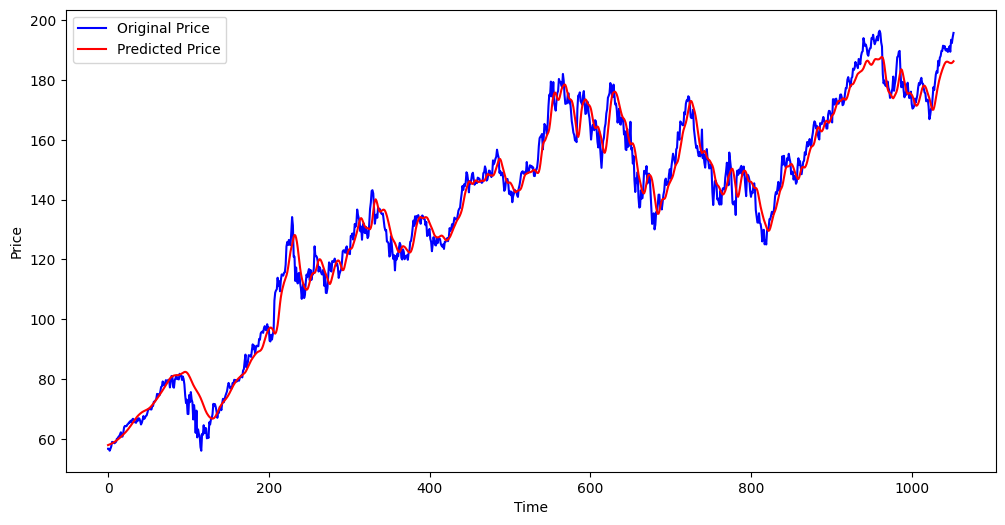

In [78]:
plt.figure(figsize = (12,6))
plt.plot(y_test_original ,'b',label='Original Price')
plt.plot(y_predicted_original, 'r', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [79]:
input_data = scaler.fit_transform(final_df)
import keras as keras

In [80]:
input_data = scaler.fit_transform(final_df)

# Get the last 100 days of data from the testing set
x_next_day = input_data[-100:]

# Reshape the data to match the input shape of the model
x_next_day = x_next_day.reshape(1, x_next_day.shape[0], 1)

# Use the trained model to predict the stock price for the next day
predicted_next_day_price = m2.predict(x_next_day)

# Invert the scaling to get the actual stock price
predicted_next_day_price = scaler.inverse_transform(predicted_next_day_price.reshape(-1, 1))

# Print the predicted stock price for the next day
print("Predicted Stock Price for the Next Day:", predicted_next_day_price[0, 0])

1/1 [==============================] - 0s 35ms/step
Predicted Stock Price for the Next Day: 186.70493
